<img src="https://devra.ai/analyst/notebook/3394/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">    <div style="font-size:150%; color:#FEE100"><b>Netflix 2025 User Behavior Analysis</b></div>    <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>

# Table of Contents
- [Introduction](#Introduction)
- [Data Loading and Preparation](#Data-Loading-and-Preparation)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Visualizations](#Visualizations)
- [Prediction of Recommendation Clicks](#Prediction-of-Recommendation-Clicks)
- [Discussion and Summary](#Discussion-and-Summary)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')  # Setting backend as instructed
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensure proper backend switching
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Set a style for seaborn
sns.set(style='whitegrid')

In [2]:
# Loading the datasets

# Watch history dataset
watch_history = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/watch_history.csv', 
                            delimiter=',', 
                            encoding='ascii')

# Users dataset
users = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/users.csv', 
                    delimiter=',', 
                    encoding='ascii')

# Reviews dataset
reviews = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/reviews.csv', 
                      delimiter=',', 
                      encoding='ascii')

# Recommendation logs dataset
recommendation_logs = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/recommendation_logs.csv', 
                                  delimiter=',', 
                                  encoding='ascii')

# Movies dataset
movies = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/movies.csv', 
                     delimiter=',', 
                     encoding='ascii')

# Search logs dataset
search_logs = pd.read_csv('/kaggle/input/netflix-2025user-behavior-dataset-210k-records/search_logs.csv', 
                         delimiter=',', 
                         encoding='ascii')

# Introduction
Netflix user behavior datasets for 2025 offer a fascinating glimpse into future streaming habits. While the data is complex, it holds valuable insights about user engagement, recommendations, and content preferences. If you find these insights useful, please consider upvoting the notebook.

# Data Loading and Preparation
In this section, we load various datasets including watch history, users, reviews, recommendation logs, movies, and search logs. Each dataset provides a unique window into the user behavior on Netflix.

In [3]:
# Inspect the first few rows of each dataset to get an overview
print('Watch History Head:')
print(watch_history.head())
print('\nUsers Head:')
print(users.head())
print('\nReviews Head:')
print(reviews.head())
print('\nRecommendation Logs Head:')
print(recommendation_logs.head())
print('\nMovies Head:')
print(movies.head())
print('\nSearch Logs Head:')
print(search_logs.head())

Watch History Head:
       session_id     user_id    movie_id  watch_date device_type  \
0  session_000001  user_07271  movie_0511  2025-11-13      Tablet   
1  session_000002  user_00861  movie_0588  2025-02-26      Laptop   
2  session_000003  user_05391  movie_0694  2024-12-15     Desktop   
3  session_000004  user_05192  movie_0234  2024-09-30     Desktop   
4  session_000005  user_05735  movie_0390  2024-08-04      Tablet   

   watch_duration_minutes  progress_percentage     action quality  \
0                    63.9                 34.6  completed      HD   
1                   120.1                 44.2    started      HD   
2                   572.1                 84.7    started      HD   
3                   395.3                 89.9  completed      SD   
4                    14.6                  6.2  completed      HD   

  location_country  is_download  user_rating  
0              USA        False          NaN  
1              USA        False          NaN  
2        

# Data Cleaning and Preprocessing
This section is dedicated to cleaning and preparing our datasets for analysis. We will convert date columns to datetime objects, ensure correct data types for each column, and handle any missing values or inconsistencies. Note that similar techniques will be useful when others encounter similar data-related issues.

In [4]:
# Convert string dates to datetime objects where applicable
watch_history['watch_date'] = pd.to_datetime(watch_history['watch_date'], errors='coerce')

users['subscription_start_date'] = pd.to_datetime(users['subscription_start_date'], errors='coerce')
users['created_at'] = pd.to_datetime(users['created_at'], errors='coerce')

reviews['review_date'] = pd.to_datetime(reviews['review_date'], errors='coerce')

recommendation_logs['recommendation_date'] = pd.to_datetime(recommendation_logs['recommendation_date'], errors='coerce')

search_logs['search_date'] = pd.to_datetime(search_logs['search_date'], errors='coerce')

# For movies, if the 'added_to_platform' column represents a date, then convert it
if 'added_to_platform' in movies.columns:
    movies['added_to_platform'] = pd.to_datetime(movies['added_to_platform'], errors='coerce')

# Inspect any potential missing values after conversions (for demonstration purposes)
print('Missing values in watch_history:', watch_history.isnull().sum().sum())
print('Missing values in users:', users.isnull().sum().sum())
print('Missing values in reviews:', reviews.isnull().sum().sum())
print('Missing values in recommendation_logs:', recommendation_logs.isnull().sum().sum())
print('Missing values in movies:', movies.isnull().sum().sum())
print('Missing values in search_logs:', search_logs.isnull().sum().sum())

Missing values in watch_history: 104749
Missing values in users: 4615
Missing values in reviews: 5624
Missing values in recommendation_logs: 7836
Missing values in movies: 3671
Missing values in search_logs: 14826


# Exploratory Data Analysis
Here we perform a preliminary exploration of the data. We will look into summary statistics and correlations within numeric columns where there are at least four numeric features. The movies dataset, for instance, contains several numeric variables that can reveal interesting patterns.

       release_year  duration_minutes  imdb_rating  production_budget  \
count   1040.000000       1040.000000   890.000000       3.650000e+02   
mean    2006.416346         89.112500     6.268539       1.111541e+07   
min     1953.000000          0.000000     0.500000       6.837300e+04   
25%     1998.000000         51.000000     5.300000       1.445488e+06   
50%     2006.000000         81.000000     6.400000       3.778470e+06   
75%     2016.000000        109.000000     7.400000       9.373108e+06   
max     2024.000000        586.000000    10.000000       1.973266e+08   
std       11.414524         69.298936     1.809088       2.395707e+07   

       box_office_revenue  number_of_seasons  number_of_episodes  \
count        3.310000e+02         289.000000          321.000000   
mean         6.461093e+07           7.339100          101.052960   
min          2.863700e+04           1.000000            6.000000   
25%          3.261451e+06           3.000000           54.000000   
50

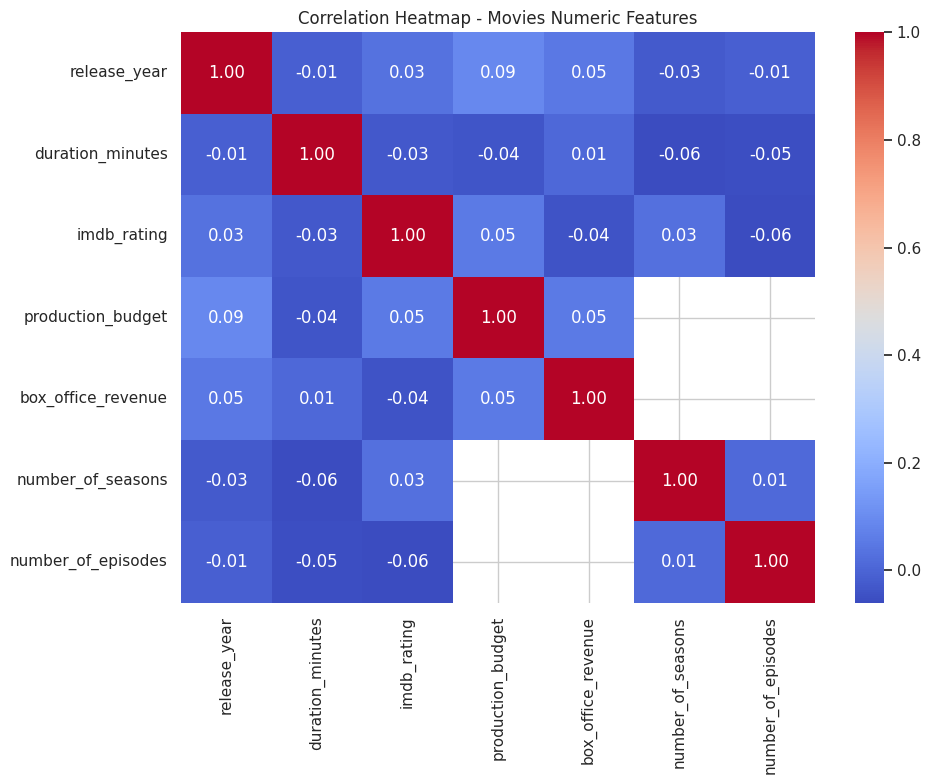

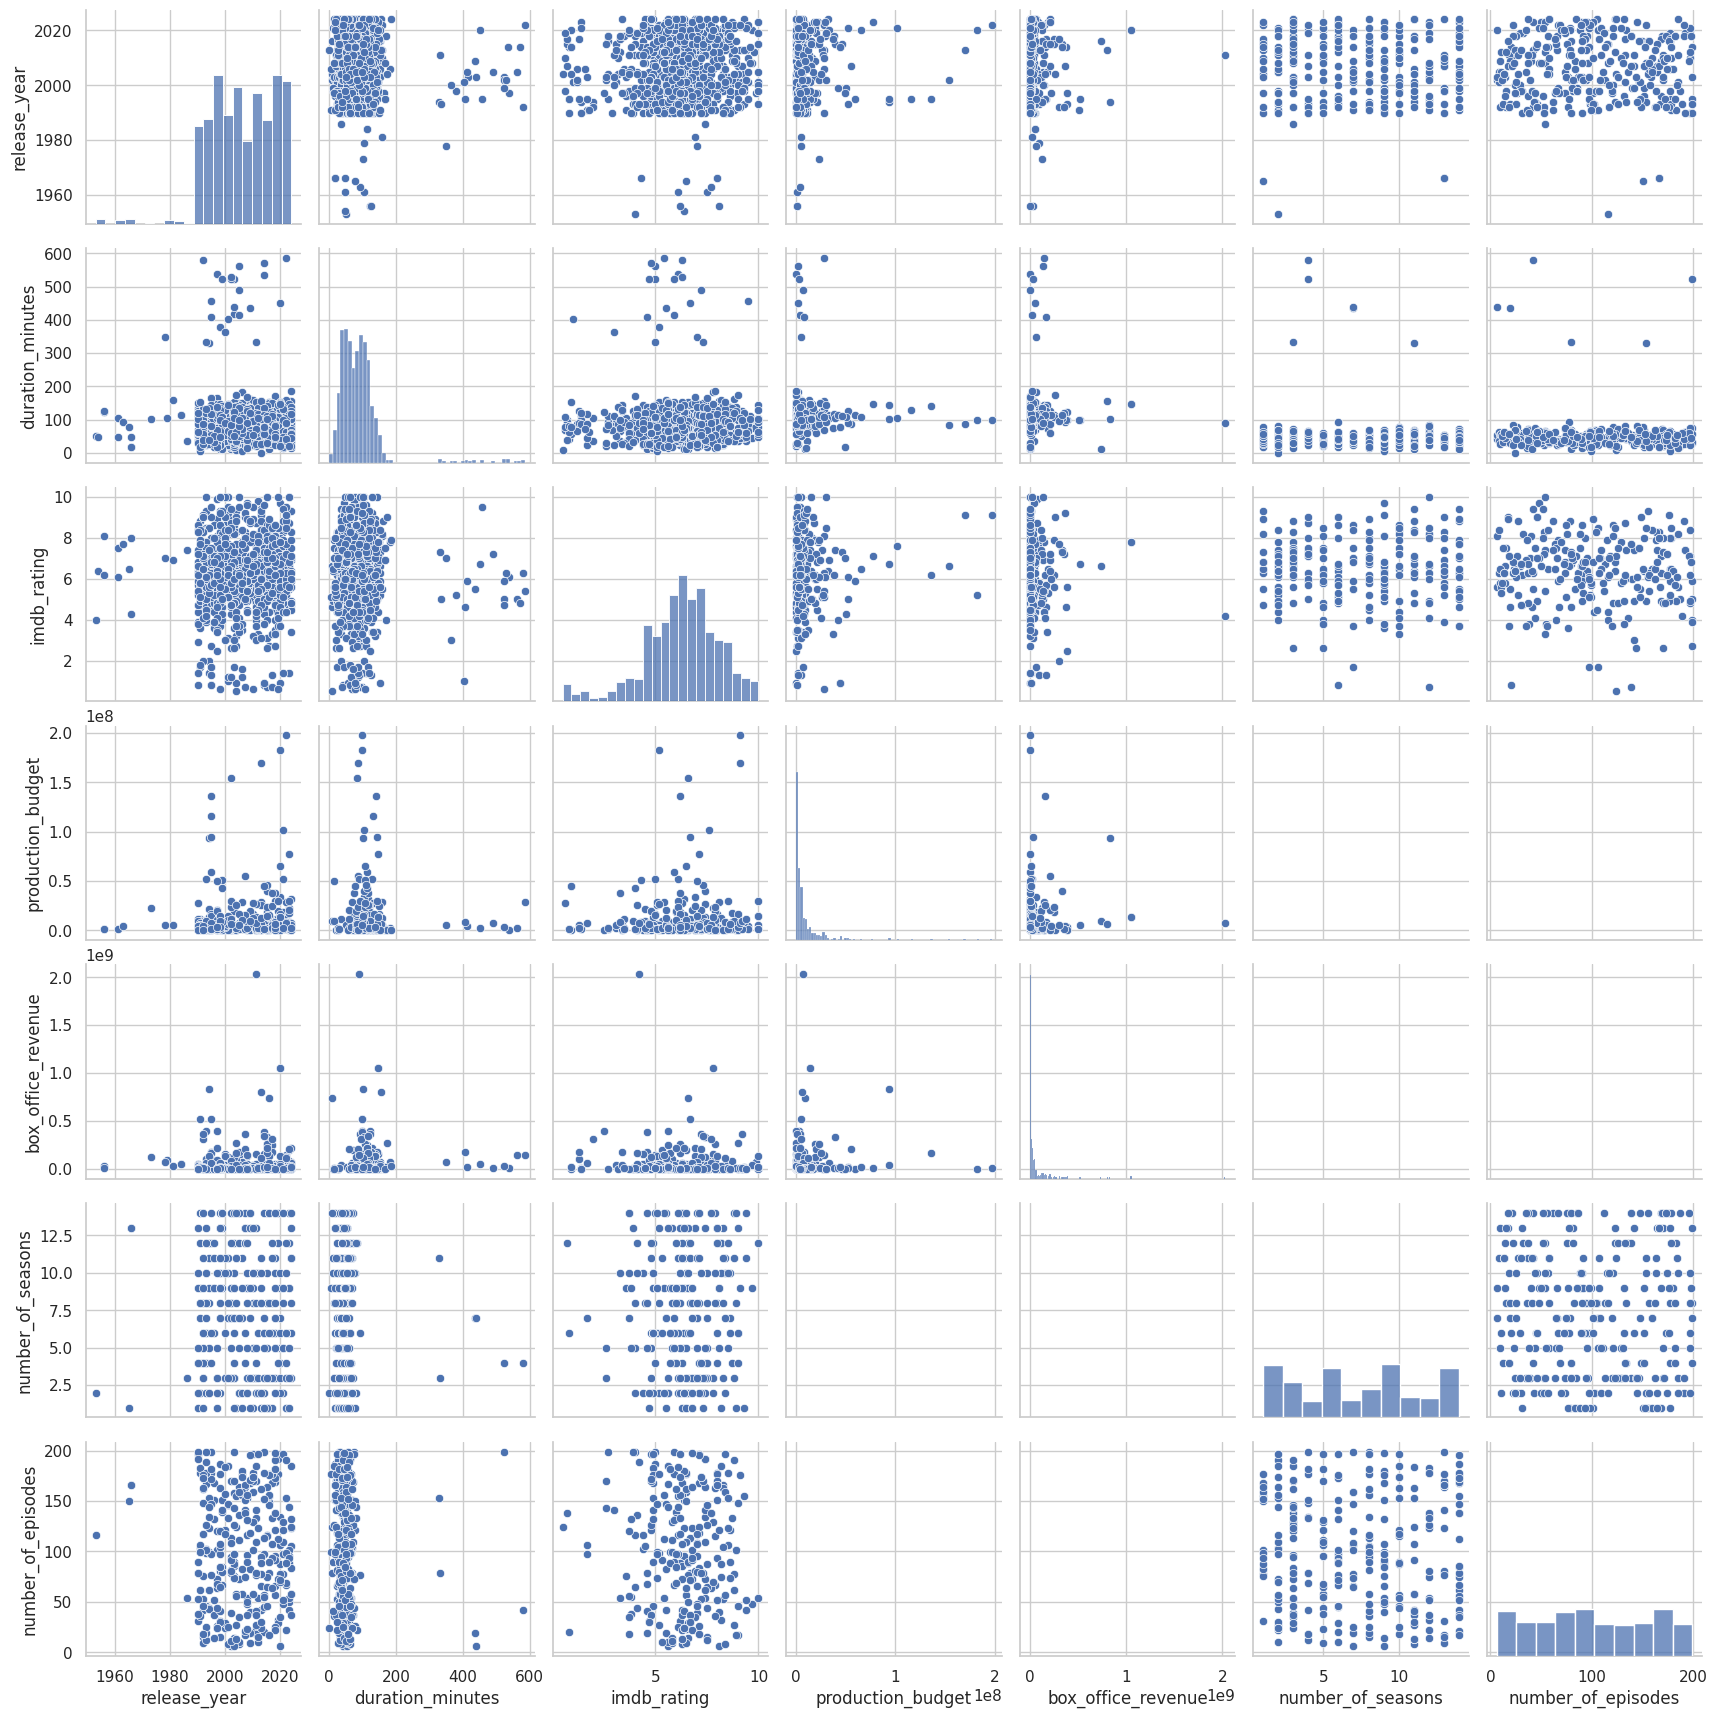

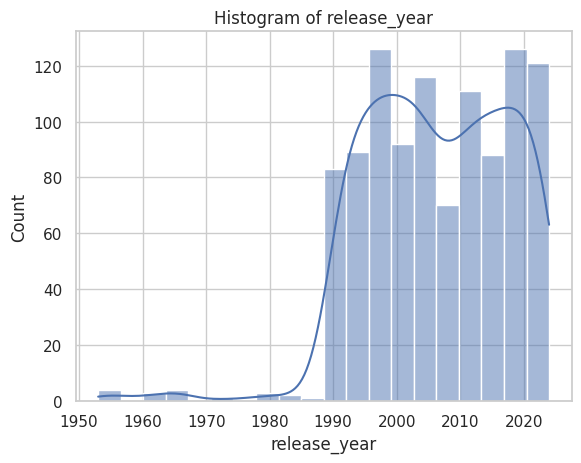

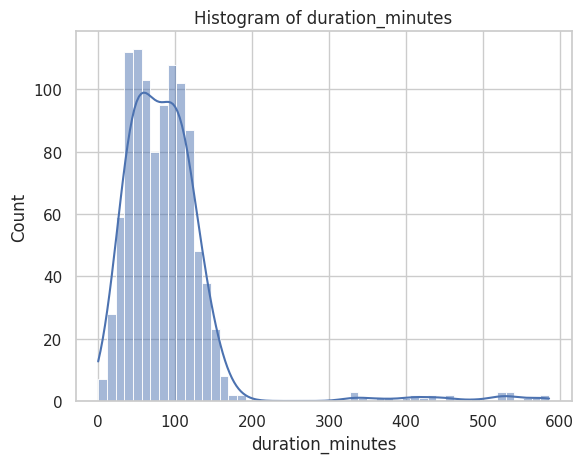

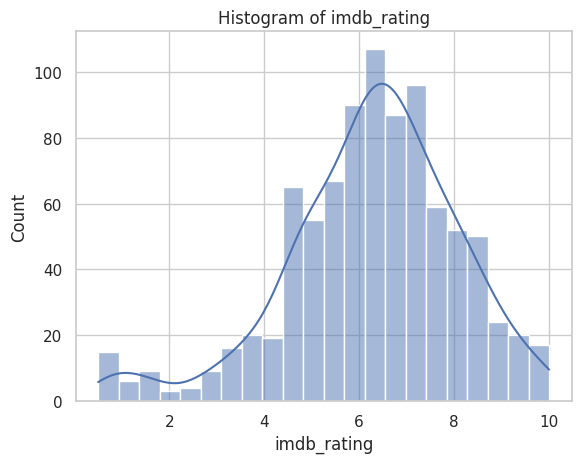

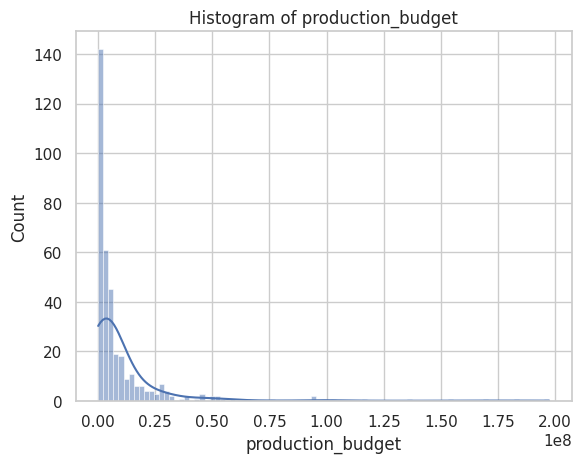

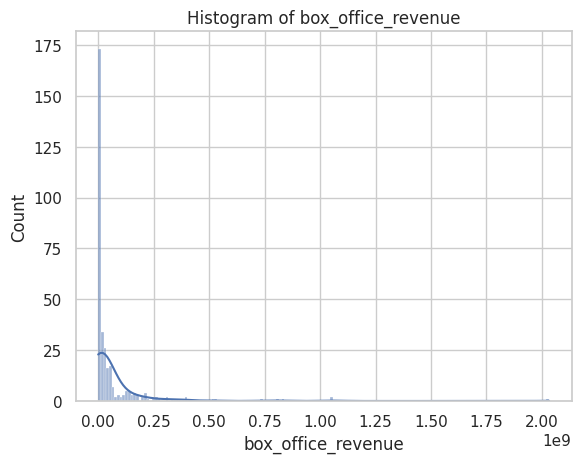

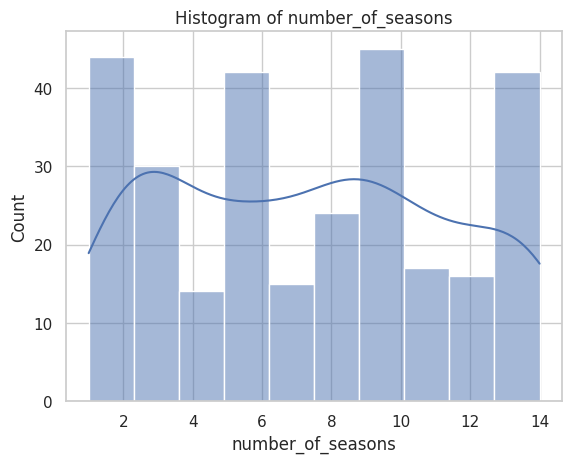

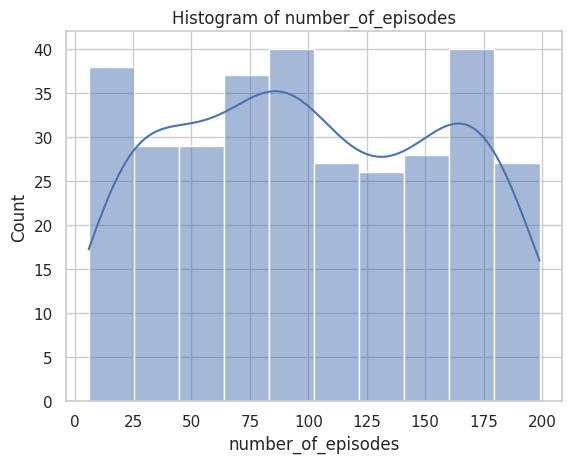

In [5]:
# Descriptive statistics for movies dataset
print(movies.describe())

# Select numeric columns from movies for correlation analysis
numeric_movies = movies.select_dtypes(include=[np.number])

if numeric_movies.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_movies.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap - Movies Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap.')

# Pair plot for a subset of numeric features if desired
if numeric_movies.shape[1] >= 4:
    sns.pairplot(numeric_movies)
    plt.show()

# Show histograms for a few numeric features in the movies dataset
for col in numeric_movies.columns:
    plt.figure()
    sns.histplot(numeric_movies[col].dropna(), kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# Visualizations
A variety of visualization methods provide different perspectives on the data. Below, we explore various metrics using count plots, box plots, and more, each adding a unique flavor to our analysis.

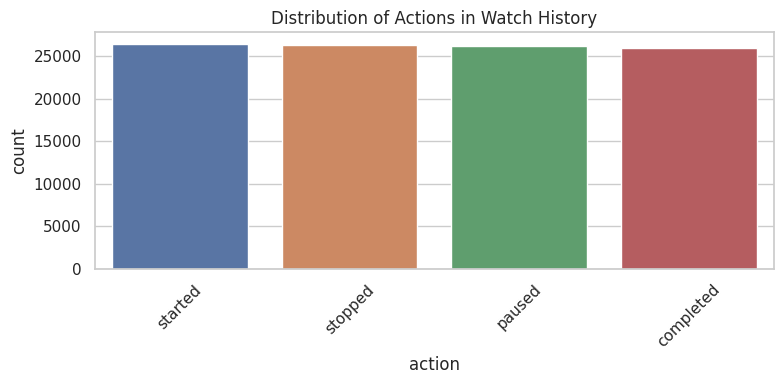

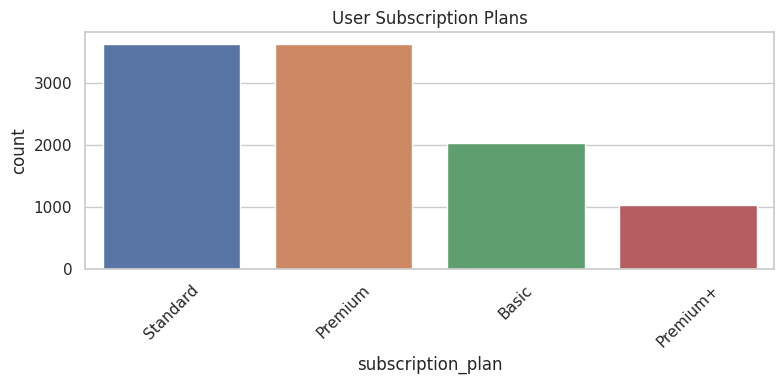

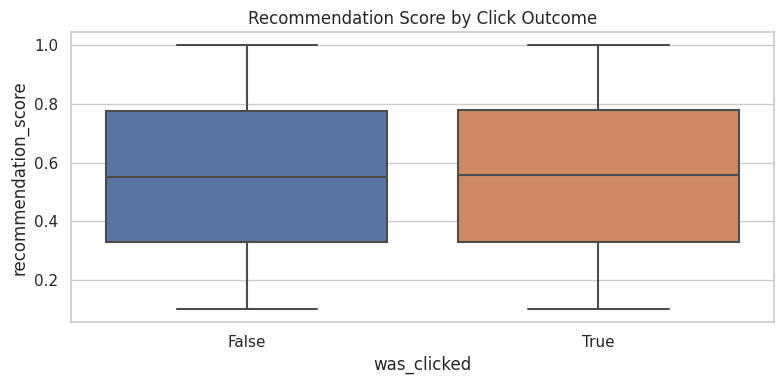

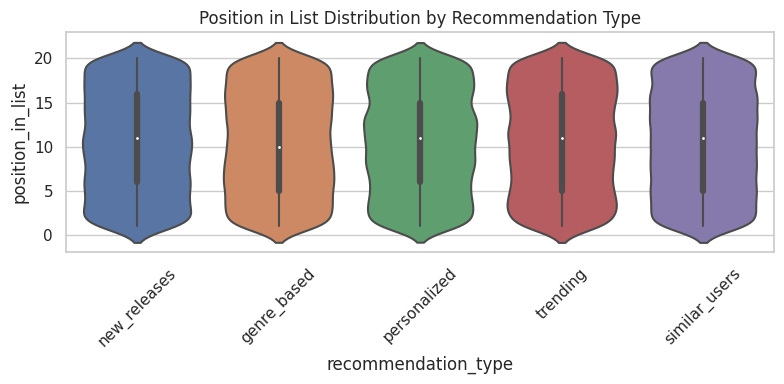

In [6]:
# Count plot for actions in watch history
plt.figure(figsize=(8, 4))
sns.countplot(data=watch_history, x='action', order=watch_history['action'].value_counts().index)
plt.title('Distribution of Actions in Watch History')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Count plot for subscription plans in users data (acting as a pie chart alternative)
plt.figure(figsize=(8, 4))
sns.countplot(data=users, x='subscription_plan', order=users['subscription_plan'].value_counts().index)
plt.title('User Subscription Plans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot for recommendation scores by clicked/not clicked
plt.figure(figsize=(8, 4))
sns.boxplot(data=recommendation_logs, x='was_clicked', y='recommendation_score')
plt.title('Recommendation Score by Click Outcome')
plt.tight_layout()
plt.show()

# Violin plot for position in list by recommendation type if desired
plt.figure(figsize=(8, 4))
sns.violinplot(data=recommendation_logs, x='recommendation_type', y='position_in_list')
plt.title('Position in List Distribution by Recommendation Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prediction of Recommendation Clicks
We now attempt to predict whether a recommendation was clicked (was_clicked) based on available features. For simplicity and to reduce modeling complexity, we use the numeric features 'recommendation_score' and 'position_in_list' from the recommendation_logs dataset. A logistic regression model is built and its performance is evaluated using the accuracy score, confusion matrix, and ROC curve.

Accuracy of Logistic Regression model: 0.85


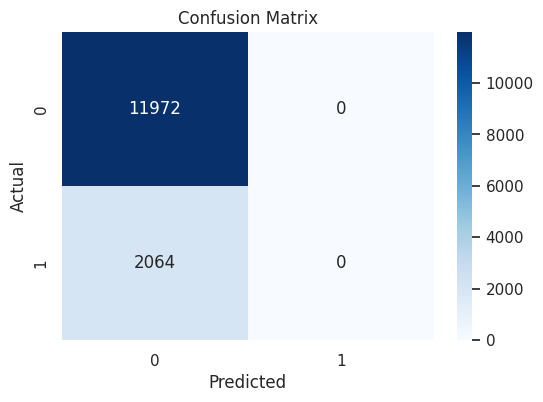

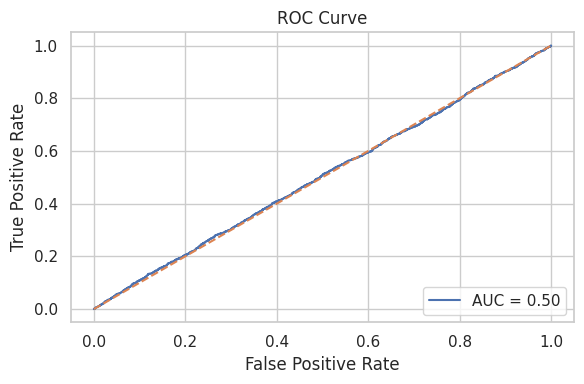

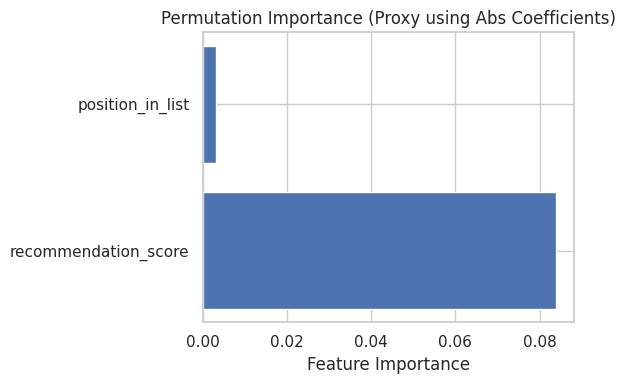

In [7]:
# Prepare data for prediction model
model_df = recommendation_logs[['recommendation_score', 'position_in_list', 'was_clicked']].dropna()

# Convert boolean target to int if needed
model_df['was_clicked'] = model_df['was_clicked'].astype(int)

X = model_df[['recommendation_score', 'position_in_list']]
y = model_df['was_clicked']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic Regression model: {acc:.2f}')

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve and AUC
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Permutation Importance (simple demonstration using coefficients as a proxy)
importances = abs(log_reg.coef_[0])
feature_names = X.columns
plt.figure(figsize=(6, 4))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Permutation Importance (Proxy using Abs Coefficients)')
plt.tight_layout()
plt.show()

# Discussion and Summary
This notebook has presented several approaches to analyze Netflix 2025 user behavior data. The data was carefully loaded, cleaned, and preprocessed, after which an exploratory analysis provided insights into underlying patterns. A variety of visualizations—ranging from heatmaps to violin plots—helped illustrate different aspects of the data. Furthermore, a simple logistic regression predictor demonstrates the practical application of machine learning to predict whether a recommendation is clicked.

The current approach leverages simple models and visualizations. Future work could involve:
- Applying more sophisticated models such as random forests or gradient boosting for prediction tasks
- Utilizing text analysis on reviews to understand sentiment in greater depth
- Integrating additional features and external datasets to enrich analysis

This exercise underscores the value of a systematic data analysis pipeline, and I hope you find the insights derived from this data interesting and useful. If you do, please consider upvoting this notebook.